
# Time Series Forecasting Models Comparison

This notebook compares several neural network architectures—LSTM (small and large), GRU and CNN—for predicting the next 1–3 samples of inertial measurement unit (IMU) data. The models are defined in separate Python modules and trained here with varying prediction horizons.


In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
import os, sys, importlib, pathlib, json
from typing import Optional
import torch
# 0) Colab drive mount (safe to re-run)
try:
    from google.colab import drive  # type: ignore
    if not os.path.isdir("/content/drive/MyDrive"):
        drive.mount('/content/drive')
except Exception:
    pass

MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/models_python"
CONFIG_JSON = "/content/drive/MyDrive/Colab Notebooks/models_python/model_config.json"

print("Looking for modules in:", MODELS_DIR)
if not os.path.isdir(MODELS_DIR):
    raise FileNotFoundError(f"Folder not found: {MODELS_DIR}")

print("Files there:", sorted(os.listdir(MODELS_DIR)))

# 1) Ensure the path is on sys.path
if MODELS_DIR not in sys.path:
    sys.path.append(MODELS_DIR)

# 2) If you want package-style imports, ensure __init__.py exists
init_path = os.path.join(MODELS_DIR, "__init__.py")
if not os.path.exists(init_path):
    # not strictly required for direct-path imports, but helpful if you want `import models_python.lstm_small`
    try:
        open(init_path, "a").close()
        print("Created empty __init__.py in models_python (package mode).")
    except Exception as e:
        print("Could not create __init__.py:", e)

# 3) Invalidate caches in case files were just added
importlib.invalidate_caches()

def import_or_load(module_name: str, file_name: Optional[str] = None):
    """
    Try `import module_name`. If it fails, try loading from MODELS_DIR/file_name (or module_name.py).
    Returns the imported module.
    """
    try:
        return importlib.import_module(module_name)
    except ModuleNotFoundError as e:
        print(f"[info] Standard import failed for '{module_name}': {e}. Trying direct file load...")
        fn = file_name or (module_name.replace(".", os.sep) + ".py")
        full_path = os.path.join(MODELS_DIR, fn)
        if not os.path.exists(full_path):
            raise FileNotFoundError(f"Expected file not found for module '{module_name}': {full_path}")
        spec = importlib.util.spec_from_file_location(module_name, full_path)
        mod = importlib.util.module_from_spec(spec)
        assert spec and spec.loader
        spec.loader.exec_module(mod)  # type: ignore
        sys.modules[module_name] = mod
        return mod

# 4) Import your modules (works whether they are package or flat files)
lstm_small = import_or_load("lstm_small")
lstm_large = import_or_load("lstm_large")
cnn_model  = import_or_load("cnn_model")
gru_model  = import_or_load("gru_model")

print("Imported:", lstm_small.__name__, lstm_large.__name__, cnn_model.__name__, gru_model.__name__)

# 5) (Optional) Load your config if it exists
if os.path.exists(CONFIG_JSON):
    with open(CONFIG_JSON) as f:
        cfg = json.load(f)
    print("Loaded config keys:", list(cfg.keys()))
else:
    print("Config JSON not found (optional):", CONFIG_JSON)


Looking for modules in: /content/drive/MyDrive/Colab Notebooks/models_python
Files there: ['.ipynb_checkpoints', '__init__.py', '__pycache__', 'cnn_model.py', 'common.py', 'gru_model.py', 'lstm_large.py', 'lstm_small.py', 'model_config.json', 'tcn_model.py']
Imported: lstm_small lstm_large cnn_model gru_model
Loaded config keys: ['data_path', 'tag', 'window_size', 'horizons', 'models']


In [63]:
import sys, json, importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# point to your folder with the model .py files + model_config.json
sys.path.append("/content/drive/MyDrive/Colab Notebooks/models_python/")
sys.path.append("/content/drive/MyDrive/Colab Notebooks/utils/")


import common, lstm_small, lstm_large, gru_model, cnn_model ,tcn_model
from visualization import plot_k_best_worst_segments
from data_handler import build_dataset_from_recordings, train_val_test_split
importlib.reload(common)
importlib.reload(lstm_small)
importlib.reload(lstm_large)
importlib.reload(gru_model)
importlib.reload(cnn_model)
importlib.reload(tcn_model)

print("has build_model?", hasattr(lstm_small, "build_model"))

from data_handler import (
    load_recording_csv, split_by_expected_rate, standardize
)
# config
config_path = "/content/drive/MyDrive/Colab Notebooks/models_python/model_config.json"
with open(config_path, "r") as f:
    CFG = json.load(f)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
%matplotlib inline


has build_model? True


In [64]:
# --- calibrated, segmented, windowed replacement ---
import numpy as np
import pandas as pd



# --------- resolve config ---------
data_path_override = "/content/drive/MyDrive/Colab Notebooks/epsilon_52Hz/MayaRec1.csv"  # or None
EXPECTED_HZ = float(CFG.get("expected_hz", 52.0))   # change if your file is 104 Hz
DATA_PATH   = data_path_override or CFG["data_path"]
TAG         = CFG.get("tag", None)                  # kept for compatibility; not used here
FEATURES    = list(CFG.get("features", ["x","y","z"]))
WINDOW      = int(CFG["window_size"])
HORIZONS    = list(CFG["horizons"])                 # e.g. [1,2,3]

# --------- load calibrated recording ---------
# CSV must contain a calibration row (a cell with 'calibration_file' and JSON next to it)
rec = load_recording_csv(DATA_PATH, expected_hz=EXPECTED_HZ, require_acc=True, drop_head=10)
assert rec is not None, "Calibrated load failed (missing calibration row or too short after drop_head)."

# --------- segment by expected sampling rate (avoid crossing gaps) ---------
min_len_needed = max(32, WINDOW + max(HORIZONS) + 1)
segs = split_by_expected_rate(rec.timestamps_us, expected_hz=EXPECTED_HZ, jump_factor=1.5, min_len=min_len_needed)

# --------- build feature matrix X from calibrated arrays ---------
# Map generic names to calibrated columns
name_map = {"x":"gx", "y":"gy", "z":"gz"}
resolved = [name_map.get(c, c) for c in FEATURES]  # "x"->"gx", etc.

# Column providers
cols = {
    "gx": rec.gyro[:, 0], "gy": rec.gyro[:, 1], "gz": rec.gyro[:, 2],
}
if rec.acc is not None:
    cols.update({"ax": rec.acc[:, 0], "ay": rec.acc[:, 1], "az": rec.acc[:, 2]})

missing = [c for c in resolved if c not in cols]
assert not missing, f"Requested FEATURES not available in calibrated data: {missing}"

# Full arrays
X_all = np.stack([cols[c] for c in resolved], axis=1).astype(np.float32)   # inputs (e.g., gx,gy,gz,(ax,ay,az))
Y_all = rec.gyro.astype(np.float32)                                        # targets = future gyro (gx,gy,gz)

# --------- standardize inputs (and optionally targets) ---------
Xn, X_mu, X_sigma = standardize(X_all, eps=1e-8)
Yn, Y_mu, Y_sigma = standardize(Y_all, eps=1e-8)   # keep if you want normalized targets; remove if not

# --------- windowing that respects segments ---------
def make_windows_by_segments(Xarr, Yarr, window: int, horizon: int, segments):
    """
    Produce windows across multiple continuous segments without crossing boundaries.
    Returns:
        seqs: (N, window, Din)
        tars: (N, horizon, Dout)
    """
    Din, Dout = Xarr.shape[1], Yarr.shape[1]
    seqs, tars = [], []
    for (s, e) in segments:
        # for each start i in [s, e - (window + horizon) + 1)
        end = e - window - horizon + 1
        for i in range(s, max(end, s)):
            seqs.append(Xarr[i:i+window, :])
            tars.append(Yarr[i+window:i+window+horizon, :])
    if len(seqs) == 0:
        return (np.empty((0, window, Din), dtype=Xarr.dtype),
                np.empty((0, horizon, Dout), dtype=Yarr.dtype))
    return np.stack(seqs), np.stack(tars)

# Build windows for each horizon (inputs = Xn; targets = Yn for normalized, or Y_all if you prefer raw)
win_data = {}
for h in HORIZONS:
    seqs, tars = make_windows_by_segments(Xn, Yn, WINDOW, h, segs)  # use Y_all instead of Yn for raw targets
    win_data[h] = (seqs, tars)

# Example usage: horizon=3
seqs3, tars3 = win_data[3]
print("Inputs (N, W, Din):", seqs3.shape, "Targets (N, H, Dout):", tars3.shape)

# ---- what you had before, now aligned to calibrated flow ----
# X  -> X_all (raw calibrated inputs)
# Xn -> Xn    (standardized inputs)
# make_windows -> handled by make_windows_by_segments for each horizon into win_data[h]


Inputs (N, W, Din): (9566, 30, 3) Targets (N, H, Dout): (9566, 3, 3)


In [65]:
from torch.utils.data import TensorDataset, DataLoader
import time, numpy as np
import torch

# ---- sync helper ----
def _sync():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

def measure_single_sample_latency(model, sample_x, device, repeats=200, warmup=20):
    model.eval()
    sample_x = sample_x.to(device)
    times = []
    with torch.inference_mode():
        for _ in range(warmup):
            _ = model(sample_x)
        _sync()
        for _ in range(repeats):
            t0 = time.perf_counter()
            _ = model(sample_x)
            _sync()
            t1 = time.perf_counter()
            times.append((t1 - t0) * 1000.0)
    arr = np.array(times, dtype=np.float64)
    return {
        "lat_ms_mean": float(arr.mean()),
        "lat_ms_p50":  float(np.percentile(arr, 50)),
        "lat_ms_p90":  float(np.percentile(arr, 90)),
    }

def measure_throughput(model, loader, device):
    model.eval()
    n_samples = 0
    t0 = time.perf_counter()
    with torch.inference_mode():
        for x, _ in loader:
            x = x.to(device)
            _ = model(x)
            n_samples += x.size(0)
        _sync()
    t1 = time.perf_counter()
    elapsed = t1 - t0
    thr = n_samples / max(elapsed, 1e-9)
    return float(thr)

results = []

BUILDERS = {
    "LSTMSmall": lstm_small.build_model,
    "LSTMLarge": lstm_large.build_model,
    "GRUModel":  gru_model.build_model,
    "CNNTimeSeries": cnn_model.build_model,
    "TCNModel": tcn_model.build_model,        # <-- new
}

for h in HORIZONS:
    print(f"\n=== Horizon {h} ===")

    # WINDOWS: (N, W, Din), TARGETS: (N, h, 3)  — horizon is explicit
    Xseq, Yseq = make_windows_by_segments(Xn, Yn, WINDOW, h, segs)

    if len(Xseq) == 0:
        print("Not enough samples for this window/horizon; skipping.")
        continue

    # Basic sanity checks to prevent shape mismatches in the loss
    assert Xseq.ndim == 3 and Yseq.ndim == 3, f"bad shapes: X{Xseq.shape} Y{Yseq.shape}"
    assert Xseq.shape[0] == Yseq.shape[0], "batch mismatch"
    assert Yseq.shape[1] == h and Yseq.shape[2] == 3, f"targets must be (N,{h},3), got {Yseq.shape}"

    n = len(Xseq)
    split = int(n * 0.8)
    Xtr, Ytr = Xseq[:split], Yseq[:split]
    Xva, Yva = Xseq[split:], Yseq[split:]

    tr_ds = TensorDataset(torch.from_numpy(Xtr).float(), torch.from_numpy(Ytr).float())
    va_ds = TensorDataset(torch.from_numpy(Xva).float(), torch.from_numpy(Yva).float())

    for model_key, builder in BUILDERS.items():
        if model_key not in CFG["models"]:
            raise KeyError(f"Missing model section in JSON: '{model_key}'")
        model_cfg = CFG["models"][model_key]

        epochs     = int(model_cfg.get("epochs", 10))
        batch_size = int(model_cfg.get("batch_size", 64))
        lr         = float(model_cfg.get("lr", 1e-3))

        train_loader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True,  drop_last=False)
        val_loader   = DataLoader(va_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # Build model with the current horizon; output should be (B, h, 3)
        model = builder(input_size=len(FEATURES), horizon=h, cfg=model_cfg)

        tr_hist, va_hist = common.fit(model, train_loader, val_loader, epochs=epochs, lr=lr, device=DEVICE)
        val_mse = common.evaluate(model, val_loader, device=DEVICE)

        # ---- Inference timing ----
        ex = torch.from_numpy((Xva if len(Xva) > 0 else Xtr)[0:1]).float()  # (1, W, Din)
        va_for_thr = val_loader if len(Xva) > 0 else train_loader

        lat = measure_single_sample_latency(model, ex, DEVICE, repeats=200, warmup=20)
        thr = measure_throughput(model, va_for_thr, DEVICE)

        row = {
            "model": model_key,
            "horizon": h,
            "params": common.count_params(model),
            "train_last_mse": float(tr_hist[-1]),
            "val_mse": float(val_mse),
            "epochs": epochs,
            "batch_size": batch_size,
            "lr": lr,
            "lat_ms_mean": lat["lat_ms_mean"],
            "lat_ms_p50":  lat["lat_ms_p50"],
            "lat_ms_p90":  lat["lat_ms_p90"],
            "throughput_sps": thr,
        }
        # keep weights for saving
        row["model_state_dict"] = model.state_dict()
        results.append(row)

        print(f"{model_key}: val_mse={val_mse:.6f}, "
              f"lat_mean={row['lat_ms_mean']:.3f} ms, "
              f"p50={row['lat_ms_p50']:.3f} ms, "
              f"p90={row['lat_ms_p90']:.3f} ms, "
              f"thr={row['throughput_sps']:.1f} samples/s, "
              f"params={row['params']}")

print("\nTraining + timing complete.")



=== Horizon 1 ===
LSTMSmall: val_mse=0.019182, lat_mean=0.271 ms, p50=0.263 ms, p90=0.297 ms, thr=76195.9 samples/s, params=4835
LSTMLarge: val_mse=0.013573, lat_mean=0.374 ms, p50=0.370 ms, p90=0.392 ms, thr=75946.0 samples/s, params=51139
GRUModel: val_mse=0.016283, lat_mean=0.262 ms, p50=0.255 ms, p90=0.288 ms, thr=63128.5 samples/s, params=3651
CNNTimeSeries: val_mse=0.898708, lat_mean=0.235 ms, p50=0.232 ms, p90=0.256 ms, thr=83311.4 samples/s, params=419
TCNModel: val_mse=0.112654, lat_mean=1.413 ms, p50=1.387 ms, p90=1.507 ms, thr=31142.3 samples/s, params=107779

=== Horizon 2 ===
LSTMSmall: val_mse=0.053004, lat_mean=0.265 ms, p50=0.261 ms, p90=0.288 ms, thr=78348.1 samples/s, params=4934
LSTMLarge: val_mse=0.037586, lat_mean=0.368 ms, p50=0.365 ms, p90=0.386 ms, thr=75265.4 samples/s, params=51334
GRUModel: val_mse=0.048966, lat_mean=0.251 ms, p50=0.245 ms, p90=0.275 ms, thr=79964.5 samples/s, params=3750
CNNTimeSeries: val_mse=0.919505, lat_mean=0.240 ms, p50=0.234 ms, p90=

In [66]:
results_df = pd.DataFrame(results).sort_values(["horizon", "val_mse"]).reset_index(drop=True)


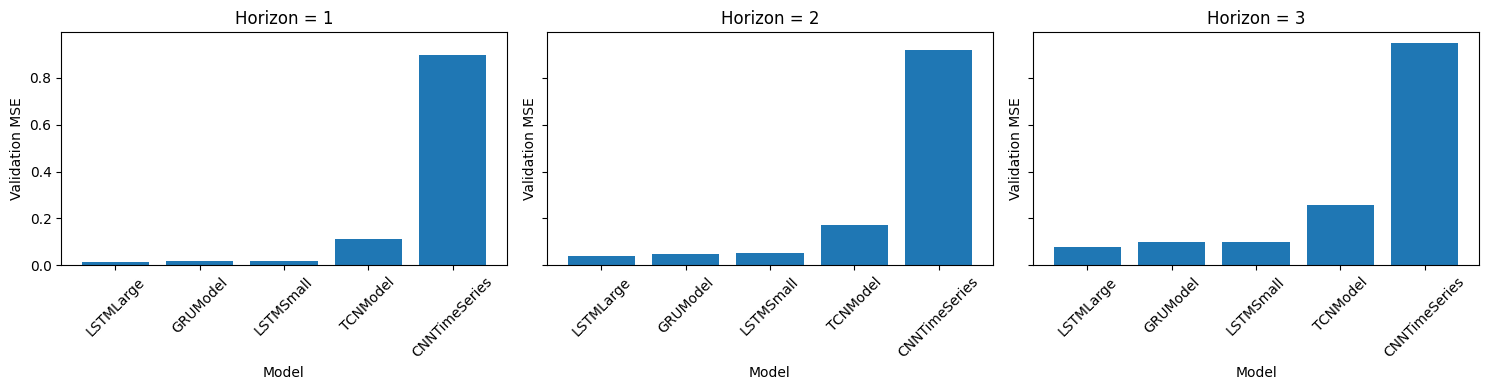

In [67]:
# Plot MSE for each model across horizons (expects columns: model, horizon, val_mse)
horizons = sorted(results_df["horizon"].unique())
n = len(horizons)

fig, axes = plt.subplots(1, n, figsize=(5 * n, 4), sharey=True)
axes = [axes] if n == 1 else axes

for ax, h in zip(axes, horizons):
    sub = results_df[results_df["horizon"] == h].copy()
    if sub.empty:
        ax.set_visible(False)
        continue
    sub = sub.sort_values("val_mse")
    ax.bar(sub["model"], sub["val_mse"])
    ax.set_title(f"Horizon = {h}")
    ax.set_xlabel("Model")
    ax.set_ylabel("Validation MSE")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


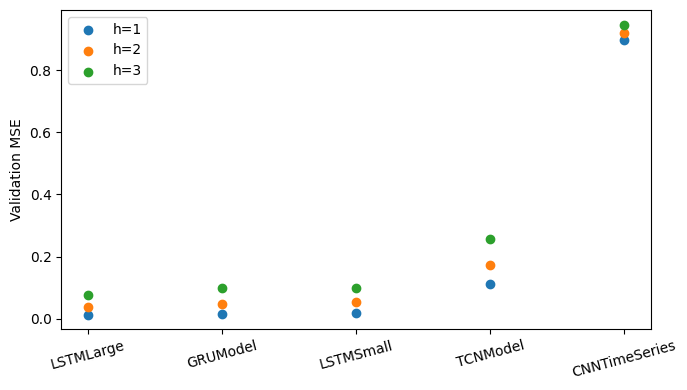

In [68]:
fig, ax = plt.subplots(figsize=(7,4))
for h in sorted(results_df["horizon"].unique()):
    sub = results_df[results_df["horizon"] == h]
    ax.scatter(sub["model"], sub["val_mse"], marker="o", label=f"h={h}")
ax.set_ylabel("Validation MSE")
ax.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

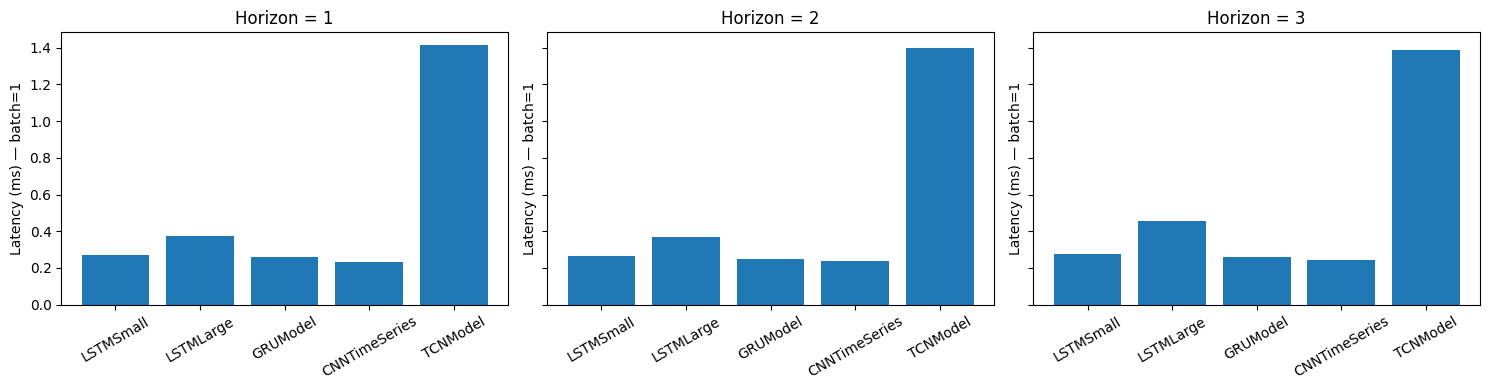

In [69]:
# Bar plot of single-sample latency (mean) per model per horizon
horizons = sorted(set(r["horizon"] for r in results))
fig, axes = plt.subplots(1, len(horizons), figsize=(5*len(horizons), 4), sharey=True)
axes = [axes] if len(horizons) == 1 else axes

for ax, h in zip(axes, horizons):
    sub = [r for r in results if r["horizon"] == h]
    if not sub:
        ax.set_visible(False); continue
    labels = [r["model"] for r in sub]
    vals   = [r["lat_ms_mean"] for r in sub]
    ax.bar(labels, vals)
    ax.set_title(f"Horizon = {h}")
    ax.set_ylabel("Latency (ms) — batch=1")
    ax.tick_params(axis="x", rotation=30)

plt.tight_layout(); plt.show()


In [70]:
# ==== Grid Search over model hyperparams with accuracy + latency tracking ====
import itertools, time, numpy as np, pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch

# ------- timing helpers -------
def _sync():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

@torch.inference_mode()
def measure_avg_latency(model, sample_x, device, repeats=50, warmup=10):
    model.eval()
    x = sample_x.to(device)
    # warmup
    for _ in range(warmup):
        _ = model(x)
    _sync()
    # timed
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = model(x)
        _sync()
        t1 = time.perf_counter()
        times.append((t1 - t0) * 1000.0)  # ms
    arr = np.array(times, dtype=np.float64)
    return {
        "lat_ms_mean": float(arr.mean()),
        "lat_ms_p50":  float(np.percentile(arr, 50)),
        "lat_ms_p90":  float(np.percentile(arr, 90)),
        "lat_ms_std":  float(arr.std(ddof=1)),
    }

@torch.inference_mode()
def measure_avg_throughput(model, loader, device, repeats=20, warmup=3):
    model.eval()
    n_samples = sum(x.size(0) for x, _ in loader)
    # warmup
    for _ in range(warmup):
        for xb, _ in loader:
            _ = model(xb.to(device))
        _sync()
    # timed
    thr = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        for xb, _ in loader:
            _ = model(xb.to(device))
        _sync()
        t1 = time.perf_counter()
        thr.append(n_samples / max(t1 - t0, 1e-9))
    arr = np.array(thr, dtype=np.float64)
    return {
        "thr_mean_sps": float(arr.mean()),
        "thr_p50_sps":  float(np.percentile(arr, 50)),
        "thr_p90_sps":  float(np.percentile(arr, 90)),
        "thr_std_sps":  float(arr.std(ddof=1)),
    }

# ------- model builders (respect your JSON key "CNNTimeSeries") -------
BUILDERS = {
    "LSTMSmall": lstm_small.build_model,
    "LSTMLarge": lstm_large.build_model,
    "GRUModel":  gru_model.build_model,
    "CNNTimeSeries": cnn_model.build_model,  # or "CNN1D" if you renamed the JSON key
}

# ------- hyperparameter grids (edit as you like) -------
# Uses CFG["models"][name] as a base and overrides combinations below
PARAM_GRID = {
    "LSTMSmall": {
        "hidden_size": [16, 32, 64],
        "epochs":      [CFG["models"]["LSTMSmall"].get("epochs", 10)],
        "batch_size":  [CFG["models"]["LSTMSmall"].get("batch_size", 64)],
        "lr":          [CFG["models"]["LSTMSmall"].get("lr", 1e-3)],
    },
    "LSTMLarge": {
        "hidden_size": [64, 128],
        "num_layers":  [2, 3],
        "epochs":      [CFG["models"]["LSTMLarge"].get("epochs", 10)],
        "batch_size":  [CFG["models"]["LSTMLarge"].get("batch_size", 64)],
        "lr":          [CFG["models"]["LSTMLarge"].get("lr", 1e-3)],
    },
    "GRUModel": {
        "hidden_size": [16, 32, 64],
        "epochs":      [CFG["models"]["GRUModel"].get("epochs", 10)],
        "batch_size":  [CFG["models"]["GRUModel"].get("batch_size", 64)],
        "lr":          [CFG["models"]["GRUModel"].get("lr", 1e-3)],
    },
    "CNNTimeSeries": {
        "num_filters": [16, 32, 64],
        "kernel_size": [3, 5],
        "epochs":      [CFG["models"]["CNNTimeSeries"].get("epochs", 10)],
        "batch_size":  [CFG["models"]["CNNTimeSeries"].get("batch_size", 64)],
        "lr":          [CFG["models"]["CNNTimeSeries"].get("lr", 1e-3)],
    },
    "TCNModel": {
        "channels":    [32, 64, 128],
        "layers":      [3, 4],
        "kernel_size": [3, 5],
        "dropout":     [0.0, 0.1],
        "epochs":      [CFG["models"]["TCNModel"].get("epochs", 10)],
        "batch_size":  [CFG["models"]["TCNModel"].get("batch_size", 64)],
        "lr":          [CFG["models"]["TCNModel"].get("lr", 1e-3)],
    },
}

def cfg_combinations(grid: dict):
    keys = list(grid.keys())
    vals = [grid[k] for k in keys]
    for combo in itertools.product(*vals):
        yield dict(zip(keys, combo))

def merged_cfg(base: dict, override: dict):
    out = dict(base)  # shallow copy
    out.update(override)
    return out

results_grid = []

for h in HORIZONS:
    print(f"\n================= Horizon {h} =================")
    Xseq, Yseq = make_windows_by_segments(Xn, Yn, WINDOW, h, segs)
    if len(Xseq) == 0:
        print("Not enough data for this window/horizon; skipping.")
        continue

    n = len(Xseq); split = int(n * 0.8)
    Xtr, Ytr = Xseq[:split], Yseq[:split]
    Xva, Yva = Xseq[split:], Yseq[split:]

    for model_key, builder in BUILDERS.items():
        base_cfg = CFG["models"][model_key]
        grid = PARAM_GRID[model_key]

        for override in cfg_combinations(grid):
            run_cfg = merged_cfg(base_cfg, override)

            # loaders per run (because batch_size can vary)
            bs = int(run_cfg.get("batch_size", 64))
            epochs = int(run_cfg.get("epochs", 10))
            lr = float(run_cfg.get("lr", 1e-3))

            tr_ds = TensorDataset(torch.from_numpy(Xtr), torch.from_numpy(Ytr))
            va_ds = TensorDataset(torch.from_numpy(Xva), torch.from_numpy(Yva))
            train_loader = DataLoader(tr_ds, batch_size=bs, shuffle=True)
            val_loader   = DataLoader(va_ds, batch_size=bs, shuffle=False)

            # build + train
            model = builder(input_size=len(FEATURES), horizon=h, cfg=run_cfg)
            tr_hist, va_hist = common.fit(model, train_loader, val_loader,
                                          epochs=epochs, lr=lr, device=DEVICE)
            val_mse = common.evaluate(model, val_loader, device=DEVICE)

            # timing
            single_x = torch.from_numpy((Xva if len(Xva)>0 else Xtr)[0:1])  # (1, T, F)
            lat = measure_avg_latency(model, single_x, DEVICE, repeats=50, warmup=10)
            thr = measure_avg_throughput(model, val_loader, DEVICE, repeats=20, warmup=3)

            row = {
                "model": model_key,
                "horizon": h,
                "params": common.count_params(model),
                "val_mse": float(val_mse),
                "epochs": epochs,
                "batch_size": bs,
                "lr": lr,
                **{k: v for k, v in run_cfg.items() if k not in ("epochs","batch_size","lr")},  # hyperparams
                **lat,
                **thr,
            }
            results_grid.append(row)

            print(f"{model_key} {override} -> "
                  f"MSE={val_mse:.6f}, "
                  f"lat={row['lat_ms_mean']:.3f}ms, thr={row['thr_mean_sps']:.1f} sps, "
                  f"params={row['params']}")

# Final results table
results_grid_df = pd.DataFrame(results_grid).sort_values(["horizon","val_mse"]).reset_index(drop=True)
results_grid_df



================= Horizon 1 =================
LSTMSmall {'hidden_size': 16, 'epochs': 10, 'batch_size': 64, 'lr': 0.001} -> MSE=0.032887, lat=0.269ms, thr=76717.1 sps, params=1395
LSTMSmall {'hidden_size': 32, 'epochs': 10, 'batch_size': 64, 'lr': 0.001} -> MSE=0.019688, lat=0.381ms, thr=55006.2 sps, params=4835
LSTMSmall {'hidden_size': 64, 'epochs': 10, 'batch_size': 64, 'lr': 0.001} -> MSE=0.016402, lat=0.280ms, thr=77296.3 sps, params=17859
LSTMLarge {'hidden_size': 64, 'num_layers': 2, 'epochs': 10, 'batch_size': 64, 'lr': 0.001} -> MSE=0.013367, lat=0.365ms, thr=74781.4 sps, params=51139
LSTMLarge {'hidden_size': 64, 'num_layers': 3, 'epochs': 10, 'batch_size': 64, 'lr': 0.001} -> MSE=0.013692, lat=0.603ms, thr=70881.7 sps, params=84419
LSTMLarge {'hidden_size': 128, 'num_layers': 2, 'epochs': 10, 'batch_size': 64, 'lr': 0.001} -> MSE=0.012568, lat=0.429ms, thr=59115.6 sps, params=200579
LSTMLarge {'hidden_size': 128, 'num_layers': 3, 'epochs': 10, 'batch_size': 64, 'lr': 0.001}

,model,horizon,params,val_mse,epochs,batch_size,lr,hidden_size,lat_ms_mean,lat_ms_p50,lat_ms_p90,lat_ms_std,thr_mean_sps,thr_p50_sps,thr_p90_sps,thr_std_sps,num_layers,num_filters,kernel_size
0,LSTMLarge,1,200579,0.012568,10,64,0.001,128.0,0.428914,0.426739,0.442470,0.013038,59115.613243,59697.022339,59990.749774,1923.224161,2.0,NaN,NaN
1,GRUModel,1,13443,0.013131,10,64,0.001,64.0,0.488879,0.342711,0.386035,0.723393,45443.519919,53566.456580,56794.845463,15199.065654,NaN,NaN,NaN
2,LSTMLarge,1,51139,0.013367,10,64,0.001,64.0,0.365336,0.363572,0.373476,0.013487,74781.390209,76778.192430,77562.674123,5646.143545,2.0,NaN,NaN
3,LSTMLarge,1,84419,0.013692,10,64,0.001,64.0,0.603056,0.597662,0.623056,0.038021,70881.749338,73207.258273,76237.362983,7123.582719,3.0,NaN,NaN
4,LSTMLarge,1,332675,0.013919,10,64,0.001,128.0,0.636458,0.635183,0.652636,0.012587,38582.143077,39680.252033,40076.304439,2678.015514,3.0,NaN,NaN
5,GRUModel,1,3651,0.015344,10,64,0.001,32.0,0.265679,0.258753,0.289419,0.032062,78199.371498,79578.135686,80974.853963,5909.780434,NaN,NaN,NaN
6,LSTMSmall,1,17859,0.016402,10,64,0.001,64.0,0.280043,0.275813,0.310447,0.020836,77296.314311,77342.787106,78362.163006,1161.359068,NaN,NaN,NaN
7,LSTMSmall,1,4835,0.019688,10,64,0.001,32.0,0.381046,0.372176,0.428245,0.048392,55006.223489,55526.699959,57890.310536,2662.093667,NaN,NaN,NaN
8,GRUModel,1,1059,0.028340,10,64,0.001,16.0,0.262923,0.260435,0.306145,0.027906,77779.024685,78186.589883,79684.521057,1930.657693,NaN,NaN,NaN
9,LSTMSmall,1,1395,0.032887,10,64,0.001,16.0,0.269135,0.260675,0.283263,0.047366,76717.087296,78248.403157,80025.999788,6133.956750,NaN,NaN,NaN


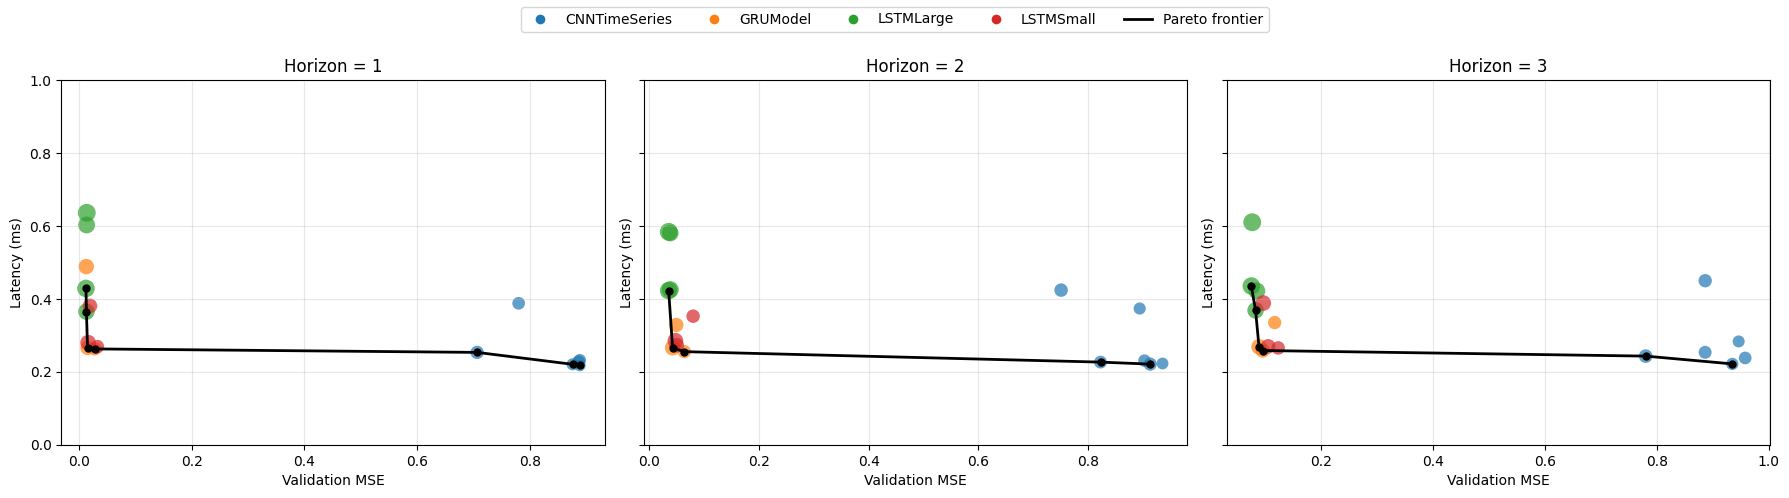

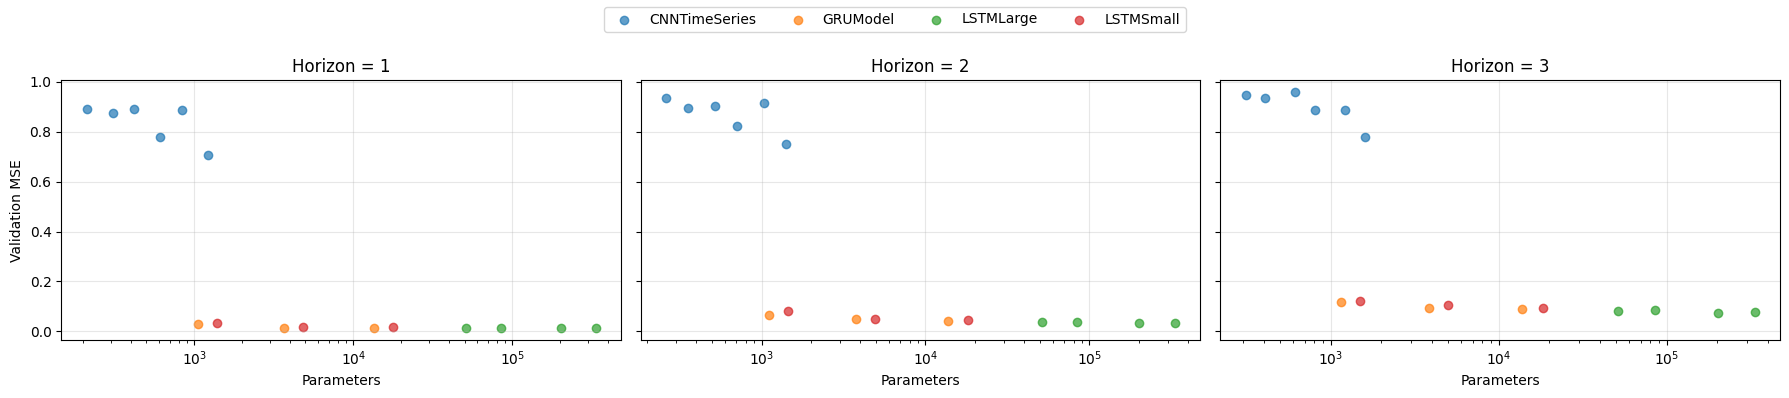

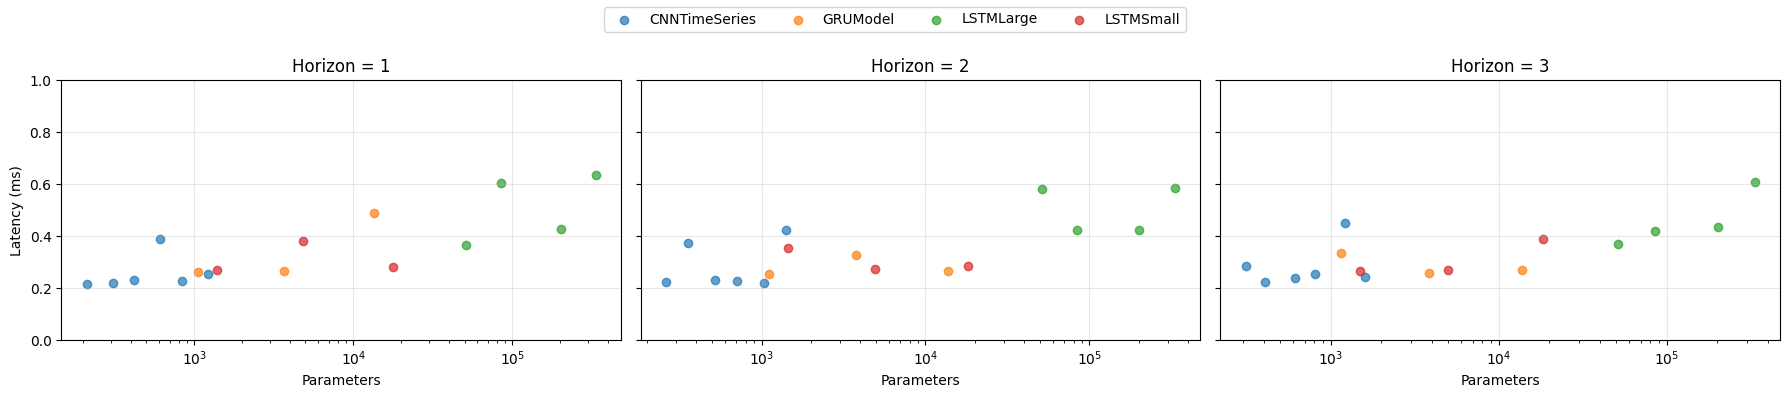

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df = results_grid_df.copy()

# -------- Pareto frontier (minimize mse & latency) per horizon --------
def pareto_frontier_2d(dsub, xcol="val_mse", ycol="lat_ms_mean"):
    d = dsub[[xcol, ycol]].to_numpy(dtype=float)
    idx = np.arange(len(d))
    order = np.argsort(d[:,0], kind="mergesort")  # sort by MSE
    d = d[order]; idx = idx[order]
    front = []
    best_y = np.inf
    for i, (x, y) in enumerate(d):
        if y < best_y:
            front.append(idx[i])
            best_y = y
    return dsub.iloc[front].index

df["is_pareto"] = False
front_ix = []
for h in sorted(df["horizon"].unique()):
    sub = df[df["horizon"] == h]
    if sub.empty:
        continue
    ix = pareto_frontier_2d(sub, xcol="val_mse", ycol="lat_ms_mean")
    front_ix.extend(ix)
df.loc[front_ix, "is_pareto"] = True

# -------- Scatter: MSE vs Latency (faceted by horizon, with Pareto overlay) --------
horizons = sorted(df["horizon"].unique())
n = len(horizons)
fig, axes = plt.subplots(1, n, figsize=(6*n, 5), sharey=True)
axes = np.atleast_1d(axes)

models = sorted(df["model"].unique())
cmap = {m: f"C{i%10}" for i, m in enumerate(models)}

for ax, h in zip(axes, horizons):
    sub = df[df["horizon"] == h].copy()
    if sub.empty:
        ax.set_visible(False)
        continue

    # points per model (bubble size ~ log params)
    for m in models:
        sm = sub[sub["model"] == m]
        if sm.empty:
            continue
        ax.scatter(
            sm["val_mse"], sm["lat_ms_mean"],
            s=30*(np.log10(sm["params"]+1)),
            alpha=0.7, label=m, color=cmap[m], edgecolor="none"
        )

    # Pareto overlay for this horizon
    pf = sub[sub["is_pareto"]].sort_values(["val_mse", "lat_ms_mean"])
    if not pf.empty:
        ax.plot(pf["val_mse"], pf["lat_ms_mean"], "-o", lw=2, ms=5, color="k", label="Pareto")

    ax.set_title(f"Horizon = {h}")
    ax.set_xlabel("Validation MSE")
    ax.set_ylabel("Latency (ms)")
    ax.grid(True, alpha=0.3)

# Legend (models + Pareto)
handles = [Line2D([0],[0], marker='o', color='w', label=m, markerfacecolor=cmap[m], markersize=8) for m in models]
handles.append(Line2D([0],[0], color='k', lw=2, label='Pareto frontier'))
fig.legend(handles=handles, loc="upper center", ncol=min(len(handles), 5))
plt.tight_layout(rect=[0,0,1,0.92])
ax.set_ylim(0, 1.0)
plt.show()
# ===== Parameters vs MSE (1x3 by horizon) =====
horizons = sorted(df["horizon"].unique())
fig, axes = plt.subplots(1, len(horizons), figsize=(6*len(horizons), 4), sharey=True)
axes = np.atleast_1d(axes)

for ax, h in zip(axes, horizons):
    sub_h = df[df["horizon"] == h]
    for m in models:
        sm = sub_h[sub_h["model"] == m]
        if sm.empty:
            continue
        ax.scatter(sm["params"], sm["val_mse"], label=m, alpha=0.7)
    ax.set_xscale("log")
    ax.set_title(f"Horizon = {h}")
    ax.set_xlabel("Parameters")
    ax.grid(True, alpha=0.3)
axes[0].set_ylabel("Validation MSE")
fig.legend(models, loc="upper center", ncol=min(len(models), 5))
plt.tight_layout(rect=[0,0,1,0.9])
plt.show()

# ===== Parameters vs Latency (1x3 by horizon) =====
fig, axes = plt.subplots(1, len(horizons), figsize=(6*len(horizons), 4), sharey=True)
axes = np.atleast_1d(axes)

for ax, h in zip(axes, horizons):
    sub_h = df[df["horizon"] == h]
    for m in models:
        sm = sub_h[sub_h["model"] == m]
        if sm.empty:
            continue
        ax.scatter(sm["params"], sm["lat_ms_mean"], label=m, alpha=0.7)
    ax.set_xscale("log")
    ax.set_ylim(0, 1.0)  # limit to 1 ms
    ax.set_title(f"Horizon = {h}")
    ax.set_xlabel("Parameters")
    ax.grid(True, alpha=0.3)
axes[0].set_ylabel("Latency (ms)")
fig.legend(models, loc="upper center", ncol=min(len(models), 5))
plt.tight_layout(rect=[0,0,1,0.9])
plt.show()


# -------- Helpers to SELECT best params programmatically (unchanged) --------
def select_by_constraints(d, max_latency_ms=None, max_mse=None, horizon=None):
    s = d.copy()
    if horizon is not None:
        s = s[s["horizon"] == horizon]
    if max_latency_ms is not None:
        s = s[s["lat_ms_mean"] <= max_latency_ms]
    if max_mse is not None:
        s = s[s["val_mse"] <= max_mse]
    return s.sort_values(["val_mse","lat_ms_mean","params"]).reset_index(drop=True)

def select_by_weighted_score(d, horizon=None, alpha=0.5, topk=5):
    s = d.copy()
    if horizon is not None:
        s = s[s["horizon"] == horizon]
    if s.empty:
        return s
    m = s[["val_mse","lat_ms_mean"]].astype(float)
    m_norm = (m - m.min()) / (m.max() - m.min() + 1e-12)
    score = alpha * m_norm["val_mse"] + (1 - alpha) * m_norm["lat_ms_mean"]
    out = s.assign(score=score).sort_values(["score","params"]).head(topk).reset_index(drop=True)
    return out


## 🔎 model

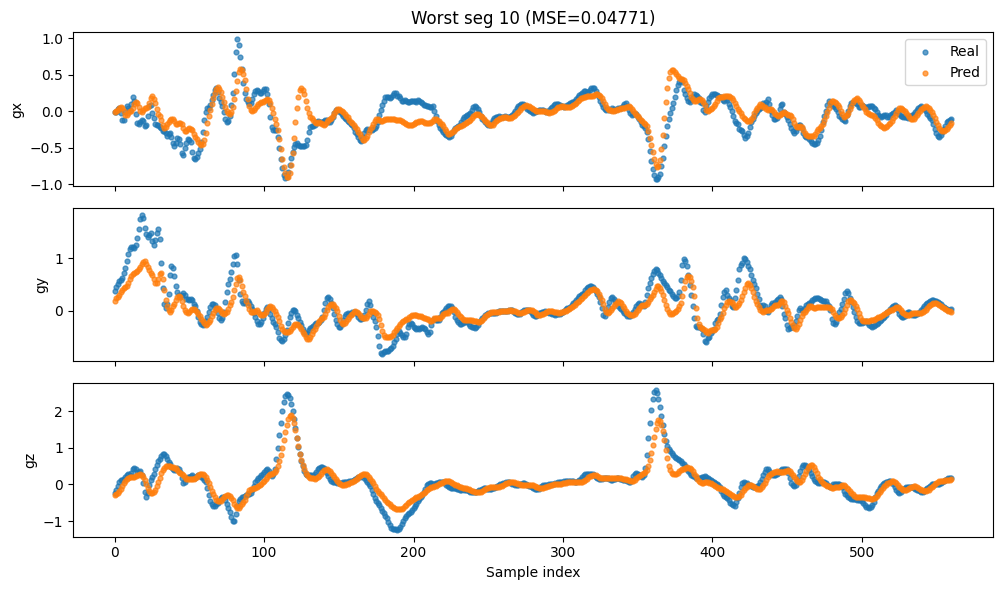

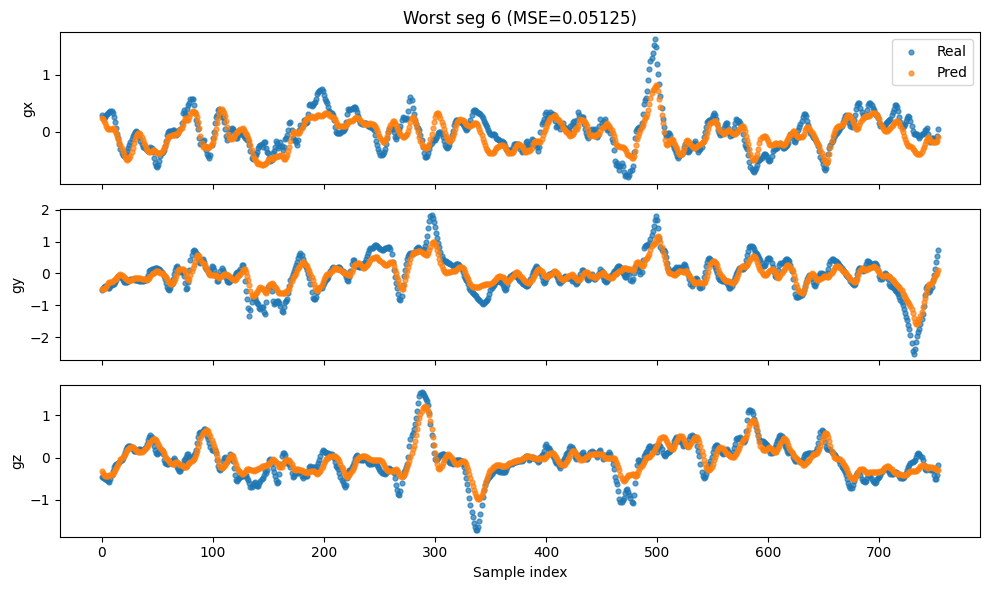

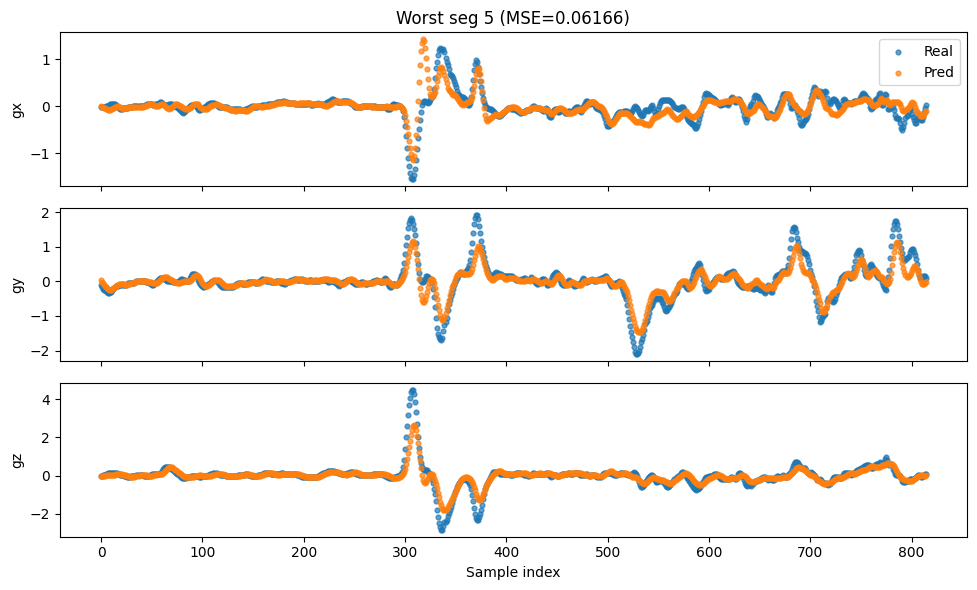

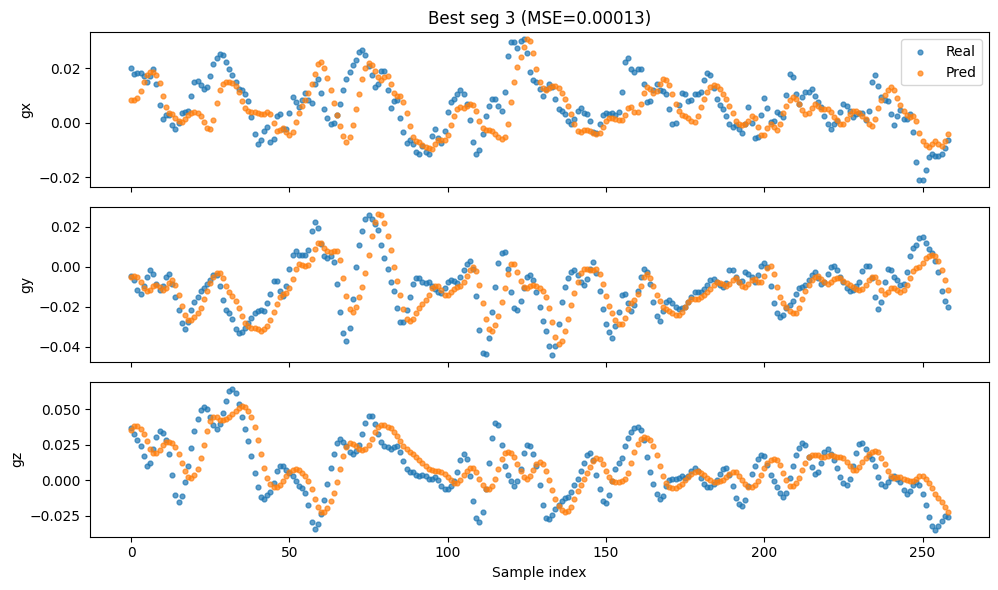

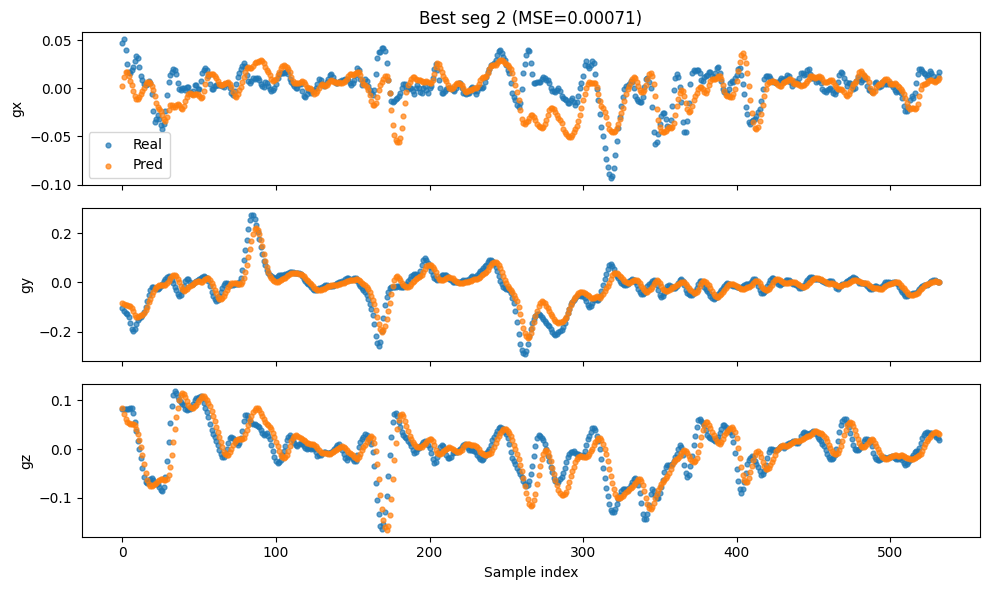

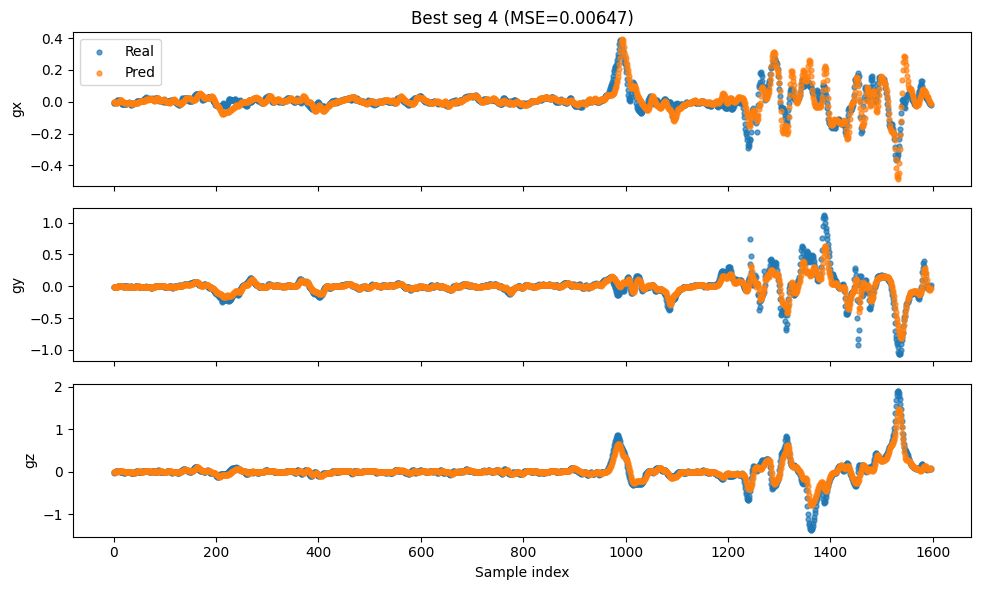

In [92]:
# === Best/Worst segment plots for EACH model on MayaRec1.csv ===
from visualization import plot_k_best_worst_segments
from data_handler import (
    load_recording_csv, segment_all_recordings, build_dataset_from_recordings
)
import torch
import torch.nn as nn
from IPython.display import display, Markdown

# ----- Config (edit if needed) -----
FILE = "/content/drive/MyDrive/Colab Notebooks/epsilon_52Hz/MayaRec1.csv"
EXPECTED_HZ = 52.0
K_PLOTS = 3                  # how many best & worst to show
HISTORY_LEN_DEFAULT = 10     # used if not inferable from your config
HORIZON_DEFAULT = 1          # used if not inferable from your config
HORIZON_IX = 0               # which horizon to visualize if model outputs [B,H,F]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ----- Load the single recording (MayaRec1 only) -----
rec = load_recording_csv(FILE, expected_hz=EXPECTED_HZ, require_acc=True, drop_head=10)
assert rec is not None, f"Could not load calibrated recording from {FILE}"
recordings = [rec]

# ----- Segment just this recording -----
segments = segment_all_recordings(recordings, expected_hz=EXPECTED_HZ, jump_factor=1.5, min_len=32)
test_segs = segments  # use all for plotting

# ----- Helper: try to infer whether model expects 3 or 6 channels -----
def infer_include_acc(m: nn.Module) -> bool:
    # Conv1d front-end (expects [B,C,T])
    for layer in m.modules():
        if isinstance(layer, nn.Conv1d):
            return layer.in_channels >= 6
    # Linear front-end (expects [B,T,F]); look for first Linear applied to features
    for layer in m.modules():
        if isinstance(layer, nn.Linear) and layer.in_features in (3, 6):
            return layer.in_features >= 6
    # Could not infer: default to gyro-only (3ch)
    return False

# ----- Helper: infer history_len / horizon from common configs -----
def infer_int(name, default):
    # look for simple globals like `history_len`, `horizon`, or HYPER dicts
    if name in globals():
        try: return int(globals()[name])
        except Exception: pass
    if "HYPER" in globals() and name in globals()["HYPER"]:
        try: return int(globals()["HYPER"][name])
        except Exception: pass
    return int(default)

# ----- Collect models: expect a dict MODELS; else fall back to single `model` -----
if "MODELS" in globals() and isinstance(MODELS, dict) and len(MODELS):
    models_to_eval = MODELS.items()
else:
    assert "model" in globals(), "Define either MODELS = {'name': model, ...} or a single `model`."
    models_to_eval = [("model", model)]

# ----- Loop and plot for each model -----
for name, mdl in models_to_eval:
    display(Markdown(f"## 🔎 {name}"))

    include_acc = infer_include_acc(mdl)
    HISTORY_LEN = infer_int("history_len", HISTORY_LEN_DEFAULT)
    HORIZON     = infer_int("horizon",     HORIZON_DEFAULT)

    # Build dataset matching this model's input channels and training windowing
    test_ds = build_dataset_from_recordings(
        recordings,
        segments=test_segs,
        include_acc=include_acc,
        history_len=HISTORY_LEN,
        horizon=HORIZON,
    )

    # Choose which axes to plot (we keep gyro x/y/z even when include_acc=True)
    axis_indices = (0, 1, 2)
    axis_labels  = ("gx", "gy", "gz")

    # Plot best & worst segments
    plot_k_best_worst_segments(
        mdl,
        test_ds,
        test_segs,
        k=K_PLOTS,
        horizon_ix=HORIZON_IX,
        axis_indices=axis_indices,
        axis_labels=axis_labels,
        device=DEVICE
    )


In [ ]:

# Optionally save results for later analysis
import json
with open('model_comparison_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print('Saved results to model_comparison_results.json')


In [ ]:
# ==============================
# Save trained models (type + config in filename)
# ==============================
import os, json
import torch

SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/trained_models"
os.makedirs(SAVE_DIR, exist_ok=True)

for row in results:
    # Build filename: Model_epochsX_batchY_lrZ_horizonH
    cfg_parts = [
        f"epochs{row['epochs']}",
        f"batch{row['batch_size']}",
        f"lr{row['lr']}",
        f"h{row['horizon']}"
    ]
    model_name = f"{row['model']}_" + "_".join(cfg_parts)
    model_path = os.path.join(SAVE_DIR, f"{model_name}.pt")

    # Save state dict
    if "model_state_dict" in row and row["model_state_dict"]:
        torch.save(row["model_state_dict"], model_path)
    else:
        print(f"[WARN] No state_dict for {model_name}, skipping save.")

    # Save metadata
    meta_path = os.path.join(SAVE_DIR, f"{model_name}_meta.json")
    with open(meta_path, "w") as f:
        json.dump(row, f, indent=2)

print(f"Models saved to {SAVE_DIR}")
